# Import Modules

In [1]:
#@title Install Packages
!pip install livelossplot --quiet
!pip install deap --quiet

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKeras, PlotLosses
from tensorflow.keras.utils import plot_model
from IPython.display import clear_output
from IPython.display import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
import math
import time
import os

#DEAP
from deap import algorithms
from deap import benchmarks
from deap import creator
from deap import tools
from deap import base

# Loading the Data and Preparing it.

In [3]:
# Download
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

# Store it
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

# Length of text
print(f'Length of text: {len(text)} characters')
vocab = sorted(set(text))

# Vocab size
print(f'{len(vocab)} unique characters')

ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

# To convert id into corresponding text
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

# Converting entire text into IDs
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))

Length of text: 1115394 characters
65 unique characters


In [4]:
# Iterating through each character in the vocabulary
for char in vocab:
    # Converting the character to its ID
    char_id = ids_from_chars(tf.strings.unicode_split(char, 'UTF-8'))

    # Printing the character and its corresponding ID
    print(f"Character: '{char}' --> ID: {char_id.numpy()[0]}")

Character: '
' --> ID: 1
Character: ' ' --> ID: 2
Character: '!' --> ID: 3
Character: '$' --> ID: 4
Character: '&' --> ID: 5
Character: ''' --> ID: 6
Character: ',' --> ID: 7
Character: '-' --> ID: 8
Character: '.' --> ID: 9
Character: '3' --> ID: 10
Character: ':' --> ID: 11
Character: ';' --> ID: 12
Character: '?' --> ID: 13
Character: 'A' --> ID: 14
Character: 'B' --> ID: 15
Character: 'C' --> ID: 16
Character: 'D' --> ID: 17
Character: 'E' --> ID: 18
Character: 'F' --> ID: 19
Character: 'G' --> ID: 20
Character: 'H' --> ID: 21
Character: 'I' --> ID: 22
Character: 'J' --> ID: 23
Character: 'K' --> ID: 24
Character: 'L' --> ID: 25
Character: 'M' --> ID: 26
Character: 'N' --> ID: 27
Character: 'O' --> ID: 28
Character: 'P' --> ID: 29
Character: 'Q' --> ID: 30
Character: 'R' --> ID: 31
Character: 'S' --> ID: 32
Character: 'T' --> ID: 33
Character: 'U' --> ID: 34
Character: 'V' --> ID: 35
Character: 'W' --> ID: 36
Character: 'X' --> ID: 37
Character: 'Y' --> ID: 38
Character: 'Z' --> ID

In [5]:
#@title Making input and target

SEQ_LENGTH = 100

# Convert to one full tensor
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

# Create sequences of 101 characters
sequences = ids_dataset.batch(SEQ_LENGTH + 1, drop_remainder=True)

# Split input and target texts
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

# Map the split function to the dataset
sequences = sequences.map(split_input_target)

# Convert sequences to numpy arrays for train_test_split
input_sequences = []
target_sequences = []
for input_text, target_text in sequences:
    input_sequences.append(input_text.numpy())
    target_sequences.append(target_text.numpy())

input_sequences = np.array(input_sequences)
target_sequences = np.array(target_sequences)

# Split the data using train_test_split
x_train, x_test, y_train, y_test = train_test_split(input_sequences, target_sequences, test_size=0.1)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (9938, 100)
y_train shape: (9938, 100)
x_test shape: (1105, 100)
y_test shape: (1105, 100)


In [6]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(64, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64, drop_remainder=True)

In [8]:
vocab_size = len(ids_from_chars.get_vocabulary())
print(vocab_size)

66


# Generating Individuals

In [9]:
# Constants representing layer types
LSTM_LAYER = -1
DROPOUT_LAYER = -2
DENSE_LAYER = -3

def generate_lstm_units():
    # Define min and max units for LSTM layers
    min_units = 700
    max_units = 1000
    return random.randint(min_units, max_units)

def generate_dropout_rate():
    # Define min and max dropout rates (as a fraction)
    min_dropout = 0.1
    max_dropout = 0.3
    return round(random.uniform(min_dropout, max_dropout), 2)

def generate_dense_neurons():
    # Define min and max neurons for Dense layers
    min_neurons = 50
    max_neurons = 66
    return random.randint(min_neurons, max_neurons)

def create_offspring():
    ind = []

    # First layer is always LSTM
    ind.extend([LSTM_LAYER, generate_lstm_units()])

    # Define max number of layers
    max_layers = 5

    for i in range(max_layers - 2):  # Subtract 2 for the first LSTM and last Dense layer
        layer_type = random.choice([LSTM_LAYER,DROPOUT_LAYER])
        if layer_type == LSTM_LAYER:
            ind.extend([LSTM_LAYER, generate_lstm_units()])
        else:
            ind.extend([DROPOUT_LAYER, generate_dropout_rate()])

    # End with a Dense layer
    # ind.extend([DENSE_LAYER, generate_dense_neurons()])

    return ind

# Generate an individual LSTM architecture
individual = create_offspring()
print(individual)

[-1, 860, -2, 0.22, -2, 0.25, -2, 0.18]


# Making models from individuals

In [10]:
def build_model(individual):
    model = Sequential()
    vocab_size = 66          # Assuming this is your vocabulary size
    embedding_dim = 256

    # Constants for layer types
    LSTM_LAYER = -1
    DROPOUT_LAYER = -2
    DENSE_LAYER = -3

    # Add the Embedding layer
    model.add(Embedding(vocab_size, embedding_dim))

    # Iterate through the individual list two elements at a time
    for i in range(0, len(individual), 2):
        layer_type = individual[i]
        param = individual[i + 1]

        if layer_type == LSTM_LAYER:
            # Add LSTM layer
            model.add(LSTM(param, return_sequences=True, stateful= False))
        elif layer_type == DROPOUT_LAYER:
            # Add Dropout layer
            model.add(Dropout(param))
        elif layer_type == DENSE_LAYER:
            # Add Dense layer
            model.add(Dense(param, activation='relu'))

    # Change the return_sequences flag of the last LSTM layer
    model.layers[-2].return_sequences = True

    # Add the final output layer
    model.add(Dense(vocab_size))

    return model

model = build_model(individual)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         16896     
                                                                 
 lstm (LSTM)                 (None, None, 860)         3842480   
                                                                 
 dropout (Dropout)           (None, None, 860)         0         
                                                                 
 dropout_1 (Dropout)         (None, None, 860)         0         
                                                                 
 dropout_2 (Dropout)         (None, None, 860)         0         
                                                                 
 dense (Dense)               (None, None, 66)          56826     
                                                                 
Total params: 3916202 (14.94 MB)
Trainable params: 39162

# CROSSOVER

In [11]:
def get_layers(ind, layer_type):
    return [i for i in range(0, len(ind), 2) if ind[i] == layer_type]

def swap(ind1, iv1, ind2, iv2, ll):
    # Swap pairs of elements. Each pair represents a layer and its parameter.
    # ll (layer length) is expected to be 2 for the new individual format.

    # Swap the layer type and its parameter from ind1 to ind2 and vice versa
    ch1 = ind1[iv1:iv1+ll]
    ch2 = ind2[iv2:iv2+ll]
    ind1[iv1:iv1+ll] = ch2
    ind2[iv2:iv2+ll] = ch1

    return ind1, ind2

def swap_layers(ind1, ind2, layer_type):
    c1, c2 = get_layers(ind1, layer_type), get_layers(ind2, layer_type)
    min_c = min(len(c1), len(c2))
    for _ in range(min_c):
        if random.random() < 1:
            i1 = random.randint(0, len(c1)-1)
            i2 = random.randint(0, len(c2)-1)
            iv1, iv2 = c1.pop(i1), c2.pop(i2)
            ind1, ind2 = swap(ind1, iv1, ind2, iv2, 2)  # Swapping pairs of elements
    return ind1, ind2
def crossover(ind1, ind2):
    LSTM_LAYER = -1
    DROPOUT_LAYER = -2
    DENSE_LAYER = -3

    ind1, ind2 = swap_layers(ind1, ind2, LSTM_LAYER)
    ind1, ind2 = swap_layers(ind1, ind2, DROPOUT_LAYER)
    ind1, ind2 = swap_layers(ind1, ind2, DENSE_LAYER)
    return ind1, ind2

ind1 = [-1, 925, -2, 0.16, -1, 952, -1, 875]
ind2 = [-1, 741, -1, 926, -1, 737, -2, 0.17]

offspring1, offspring2 = crossover(ind1, ind2)
print(offspring1)
print(offspring2)

[-1, 741, -2, 0.17, -1, 926, -1, 737]
[-1, 925, -1, 952, -1, 875, -2, 0.16]


# MUTATION

In [12]:
def mutate(layer_type, value):
    if layer_type == -1:  # LSTM Layer
        mutated_value = int(value * random.uniform(0.9, 1.1))
    elif layer_type == -2:  # Dropout Layer
        mutated_value = round(random.uniform(0.1, 0.5), 2)
    elif layer_type == -3:  # Dense Layer
        mutated_value = int(value * random.uniform(0.9, 1.1))
    else:
        raise Exception(f"mutate ERROR with layer type {layer_type}")

    return mutated_value


def mutation(ind):
    """Applies mutation to an individual."""
    for i in range(0, len(ind) - 1, 2):  # Iterate over pairs
        layer_type = ind[i]
        param = ind[i + 1]
        mutated_param = mutate(layer_type, param)
        # Update the parameter in place
        ind[i + 1] = mutated_param

    # Return the mutated individual wrapped in a tuple
    return ind,


ind = [-1, 737, -2, 0.17, -1, 741, -1, 926]

print('Before Mutation:', ind)

mu_ind, = mutation(ind)
print('After Mutation:', mu_ind)


Before Mutation: [-1, 737, -2, 0.17, -1, 741, -1, 926]
After Mutation: [-1, 700, -2, 0.33, -1, 719, -1, 909]


# Build compile Train

In [13]:
for input_example_batch, target_example_batch in train_dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


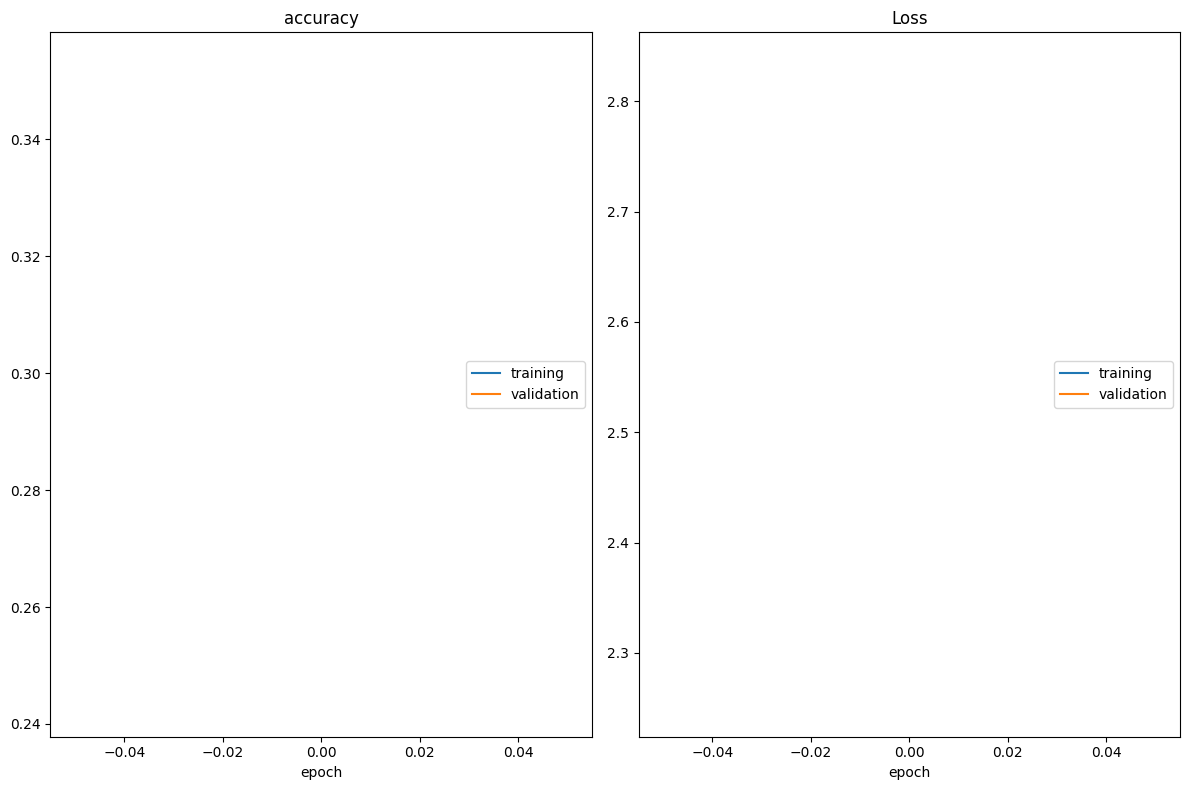

accuracy
	training         	 (min:    0.243, max:    0.243, cur:    0.243)
	validation       	 (min:    0.353, max:    0.353, cur:    0.353)
Loss
	training         	 (min:    2.833, max:    2.833, cur:    2.833)
	validation       	 (min:    2.253, max:    2.253, cur:    2.253)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 256)         16896     
                                                                 
 lstm_1 (LSTM)               (None, None, 860)         3842480   
                                                                 
 dropout_3 (Dropout)         (None, None, 860)         0         
                                                                 
 dropout_4 (Dropout)         (None, None, 860)         0         
                                                                 
 dropout_5 (Dropout)         (None, None

In [14]:
def build_compile_train(ind, epochs=20):
    model = build_model(ind)

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    history = model.fit(train_dataset, epochs=epochs,
                        validation_data=test_dataset,
                        callbacks=[PlotLossesKeras()],
                        verbose=0)

    model.summary()
    model.evaluate(test_dataset)

    return model  # Return the trained model
build_compile_train(individual,epochs=1)

# Evolutionary Implementation

In [15]:
#@title Setting up the Creator
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [16]:
#@title Create Individual and Population
toolbox = base.Toolbox()
toolbox.register("network", create_offspring)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.network)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("select", tools.selTournament, tournsize=5)

In [17]:
#@title Register Crossover and Mutation
toolbox.register("mate", crossover)
toolbox.register("mutate", mutation)

In [18]:
#@title Register Evaluation
def clamp(num, min_value, max_value):
   return max(min(num, max_value), min_value)

def compile_train(model):
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  model.fit(train_dataset, epochs=5,
                    verbose=0)
  return model

def evaluate(individual):
  try:
    model = build_model(individual)
    model = compile_train(model)
    print('.', end='')
    return 1/clamp(model.evaluate(test_dataset, verbose=0)[1], .00001, 1),
  except:
    return 1/.5,

toolbox.register("evaluate", evaluate)

In [19]:
#@title Optimize the Weights { run: "auto" }
MU = 5 #@param {type:"slider", min:5, max:1000, step:5}
NGEN = 1 #@param {type:"slider", min:1, max:100, step:1}
RGEN = 1 #@param {type:"slider", min:1, max:100, step:1}
CXPB = .6
MUTPB = .4

random.seed(64)

pop = toolbox.population(n=MU)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [20]:
def varAnd(population, toolbox, cxpb, mutpb):

    offspring = [toolbox.clone(ind) for ind in population]

    # Apply crossover and mutation on the offspring
    for i in range(1, len(offspring), 2):
        if random.random() < cxpb:
            # print('Before crossover:', type(offspring[i - 1]), type(offspring[i]))

            offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1],
                                                          offspring[i])
            # print('After crossover:', type(offspring[i - 1]), type(offspring[i]))

            del offspring[i - 1].fitness.values, offspring[i].fitness.values

    for i in range(len(offspring)):
        if random.random() < mutpb:
          # print('Before mutation:', type(offspring[i]))
          offspring[i], = toolbox.mutate(offspring[i])
          # print('After mutation:', type(offspring[i]))

          del offspring[i].fitness.values

    return offspring


def eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):

    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        print('Generation',gen)
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

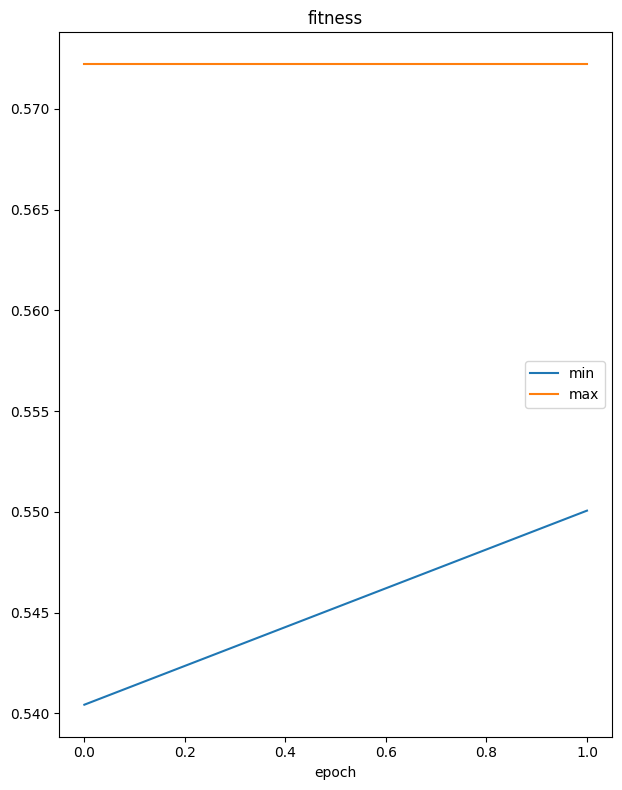

fitness
	min              	 (min:    0.540, max:    0.550, cur:    0.550)
	max              	 (min:    0.572, max:    0.572, cur:    0.572)


In [21]:
best = None
groups = { "fitness" : {"min", "max"}}
plotlosses = PlotLosses(groups=groups)

for g in range(NGEN):
  pop, logbook = eaSimple(pop, toolbox,
            cxpb=CXPB, mutpb=MUTPB, ngen=RGEN, stats=stats, halloffame=hof, verbose=False)
  best = hof[0]

  print(f"Gen ({(g+1)*RGEN})")
  for l in logbook:
    plotlosses.update({'min': 1/l["max"], 'max': 1/l["min"]})
  plotlosses.send()  # draw, update logs, etc

# Making the best model and trainig for longer epochs

In [22]:
print(best)

[-1, 851, -1, 981, -2, 0.17, -2, 0.25]


In [23]:
vocab_size = 66
embedding_dim = 256

class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        # Define LSTM layers
        self.lstm1 = tf.keras.layers.LSTM(204, return_sequences=True, return_state=True)
        self.lstm2 = tf.keras.layers.LSTM(422, return_sequences=True, return_state=True)
        self.lstm3 = tf.keras.layers.LSTM(343, return_sequences=True, return_state=True)  # No return_sequences since it's the last LSTM layer

        # Define Dropout layers
        self.dropout1 = tf.keras.layers.Dropout(0.38)
        self.dropout2 = tf.keras.layers.Dropout(0.31)

        # Final Dense layer
        self.dense = tf.keras.layers.Dense(vocab_size)


    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)

        if states is None:
            states1 = self.lstm1.get_initial_state(x)
            states2 = self.lstm2.get_initial_state(x)
            states3 = self.lstm3.get_initial_state(x)
        else:

            # Unpack states into 3 tuples, each for one LSTM layer
          states1 = (states[0], states[1])
          states2 = (states[2], states[3])
          states3 = (states[4], states[5])

    # Passing through the first LSTM layer
        x, hidden_state1, cell_state1 = self.lstm1(x, initial_state=states1, training=training)
        x = self.dropout1(x, training=training)

    # Passing through the second LSTM layer
        x, hidden_state2, cell_state2 = self.lstm2(x, initial_state=states2, training=training)
        x = self.dropout2(x, training=training)

    # Passing through the third LSTM layer
        x, hidden_state3, cell_state3 = self.lstm3(x, initial_state=states3, training=training)

        x = self.dense(x, training=training)

        if return_state:
            return x, (hidden_state1, cell_state1, hidden_state2, cell_state2, hidden_state3, cell_state3)
        else:
            return x


model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim)

In [24]:
for input_example_batch, target_example_batch in train_dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [25]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [26]:
model.compile(optimizer='adam', loss=loss)

In [27]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [36]:
EPOCHS = 30

In [37]:
def build_compile_train(ind, epochs=100):
    model = build_model(ind)

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    history = model.fit(train_dataset, epochs=epochs,
                        validation_data=test_dataset,
                        callbacks=[PlotLossesKeras()],
                        verbose=0)

    model.summary()
    model.evaluate(test_dataset)

    return model  # Return the trained model
# build_compile_train(individual,epochs=10)

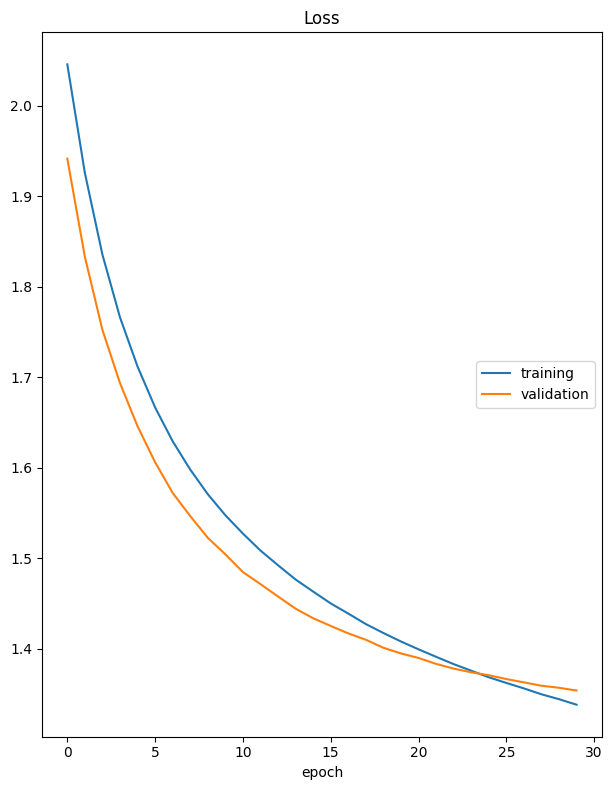

Loss
	training         	 (min:    1.338, max:    2.046, cur:    1.338)
	validation       	 (min:    1.354, max:    1.941, cur:    1.354)


In [38]:
history = model.fit(train_dataset, epochs=EPOCHS,
                    validation_data=test_dataset,
                    callbacks=[PlotLossesKeras()],
                        verbose=0)

In [42]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=0.5):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)


  @tf.function
  def generate_one_step(self, inputs, states=None):
      # Convert strings to token IDs.
      input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
      input_ids = self.ids_from_chars(input_chars).to_tensor()

      # Run the model.
      predicted_logits, states = self.model(inputs=input_ids, states=states, return_state=True)

      # Unpack the six states

      hidden_state1, cell_state1, hidden_state2, cell_state2, hidden_state3, cell_state3 = states

      # Only use the last prediction.
      predicted_logits = predicted_logits[:, -1, :]
      predicted_logits = predicted_logits / self.temperature
      # Apply the prediction mask: prevent "[UNK]" from being generated.
      predicted_logits = predicted_logits + self.prediction_mask

      # Sample the output logits to generate token IDs.
      predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
      predicted_ids = tf.squeeze(predicted_ids, axis=-1)

      # Convert from token ids to characters
      predicted_chars = self.chars_from_ids(predicted_ids)

      # Repack the states
      states = (hidden_state1, cell_state1, hidden_state2, cell_state2, hidden_state3, cell_state3)

      # Return the characters and model state.
      return predicted_chars, states


In [43]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [44]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
What do you have a doom of this sense to the war!

FRIAR LAURENCE:
Why, how far by thy short day is heard thee?

BAPTISTA:
We will not be gone, the Signior Lancaster,
That shall I never hear we have since them bed
And there's the prayer and him to the truth, and were them,
I am a man of the father to myself
To the deed dream of this death of the majesty.

GLOUCESTER:
I pray you, my lord.

Second Servingman:
O thoughts that much a contract in a world,
There remember him here and the country's power.

HERMIONE:
What have you have to the house.

First Senator:
The ground of the death, the great soul of a clain,
That we cannot be purpose to the troth,
For the child is so face of a grave prove,
And there not the soul of the eye of these
man so proclaim of some thoughts wear the ready desire.

Citizens:
My words are we promised.

CORIOLANUS:
The destruction to the world of your lord.

KING RICHARD III:
Now the sing hands of mine own sleep,
And more than the mark of the subjects in the

# other


In [35]:
# trained_model = build_compile_train(best)